In [74]:
#!/usr/bin/env python3
"""
    File Name: Feature Map Visualiser.ipynb
    Author: Thomas Frew
    Date created: 08/01/2023
    Date last modified: 24/01/2023
    Python Version: 3.11
    
    Reads "Dataset.csv", training data for a computer vision AI.
    This can be in one of two forms:

        - 2D: Images are labelled with coordinates, defining the center of some object of interest
        - 4D: Images are labelled with coordinates, defining the bounding box around some object of interest

    This data is then used with an existing CNN, to visualise
    that CNN's feature maps. Feature maps represent how the
    AI "sees" an image.
"""

'\n    File Name: CNN Trainer.ipynb\n    Author: Thomas Frew\n    Date created: 08/01/2023\n    Date last modified: 24/01/2023\n    Python Version: 3.11\n    \n    Reads "Dataset.csv", training data for a computer vision AI.\n    This can be in one of two forms:\n\n        - 2D: Images are labelled with coordinates, defining the center of some object of interest\n        - 4D: Images are labelled with coordinates, defining the bounding box around some object of interest\n\n    This data is then used to train a convolutional neural network\n    (CNN) with a preprogrammed architecture. Users can select the\n    number epochs the AI is trained for, visualise its training\n    progress and view its predictions.\n'

In [2]:
# Import tensorflow for machine learning
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Import pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Import cv2 for image manipulation
import cv2

# Import Matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Import random for rnadomisation
import random

In [3]:
# Load the training dataset. This can be generated with "2D Dataset Generator.ipynb or 4D Dataset Generator.ipynb"
dataset = pd.read_csv("Dataset.csv")

# Shuffle the dataset
dataset = dataset.sample(frac=1).reset_index(drop=True)

# Store the number of dimensions in the training data
output_dim = len(dataset.columns) - 1

# If the training dataset is 2D, then we are tracking center points
if (output_dim == 2):
    dataset.columns = ["Filename","x","y"]
    
    # Visualise the first 5 rows of the dataset
    print("The first 5 rows of your dataset are:")
    print(dataset.head())
    
# If the training dataset is 4D, then we are tracking bounding boxes
elif (output_dim == 4):
    dataset.columns = ["Filename","x1","y1","x2","y2"]

    # Visualise the first 5 rows of the dataset
    print("The first 5 rows of your dataset are:")
    print(dataset.head())
    
# Otherwise, something has gone wrong
else:
    print("Input data not in 2D (center-point) or 4D (bounding box) format.")

The first 5 rows of your dataset are:
                                            Filename   x1  y1   x2  y2
0  C:\Users\thoma\OneDrive - University of Adelai...   78  33   93  50
1  C:\Users\thoma\OneDrive - University of Adelai...   73  18   84  48
2  C:\Users\thoma\OneDrive - University of Adelai...   69  28   85  47
3  C:\Users\thoma\OneDrive - University of Adelai...  107  38  140  76
4  C:\Users\thoma\OneDrive - University of Adelai...  103  53  139  89


In [4]:
# Split the image filenames (col 0) from their coordinate data (cols 1-2 or 1-4)
coords = dataset.copy()
file_names = coords.pop('Filename')

In [5]:
# Load each file as its RGB image data
image_data = []

for fname in file_names:
    image_data.append(cv2.imread(fname))
    
# Store the length and width of each image
input_len, input_wid, channels = image_data[0].shape
    
# Report the image shape data
print(f"Your images are {input_len} by {input_wid} with {channels} color channels.")

Your images are 108 by 192 with 3 color channels.


In [6]:
# Load the AI model saved from "CNN Trainer.ipynb"
model = models.load_model("Model")

In [7]:
# Visualise the model
print("The model's structure is:")
print(model.summary())

The model's structure is:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 106, 190, 128)     3584      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 53, 95, 128)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 51, 93, 64)        73792     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 25, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 23, 44, 64)        36928     
                                                                 
 flatten_2 (Flatten)        

In [8]:
# Convert the training images and labels to numpy arrays
image_data = np.asarray(image_data)
coords = np.asarray(coords)

In [9]:
# Split up data into training and testing with a 9:1 ratio
datapoints = len(coords)
split_index = int(datapoints*0.1)

train_data = image_data[split_index:]
test_data = image_data[:split_index]

train_labels = coords[split_index:]
test_labels = coords[:split_index]

In [13]:
# Store and show the names of layers in the CNN
layer_names = [layer.name for layer in model.layers]

print("The CNN's layer are:")
print(layer_names)

The CNN's layer are:
['conv2d_6', 'max_pooling2d_4', 'conv2d_7', 'max_pooling2d_5', 'conv2d_8', 'flatten_2', 'dense_8', 'dense_9', 'dense_10', 'dense_11']


In [14]:
# Create feature map model from CNN I/O
layer_outputs = [layer.output for layer in model.layers]
feature_map_model = tf.keras.models.Model(model.input, layer_outputs)

How many feature maps would you like to view on each layer? (Reccomended: 3-7) 
>> 3
1/1 [==============================] - 0s 35ms/step


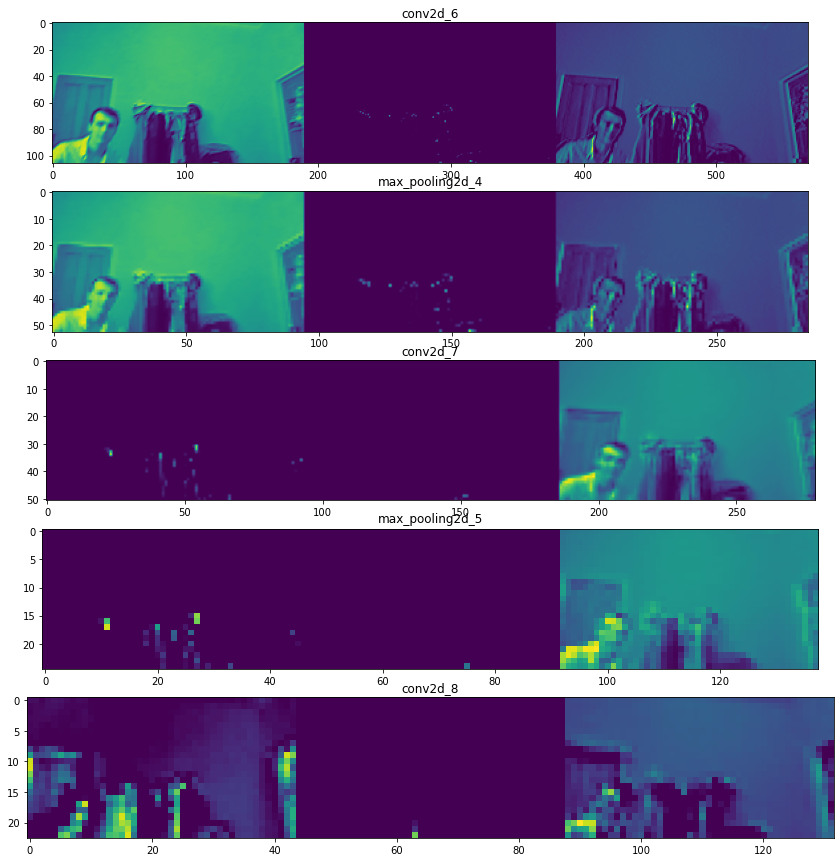

In [18]:
# Create a plot to display CNN feature maps
fig, axes = plt.subplots(conv_layers, 1, figsize=(15, 15)) 

# Ask the user to input the maximum number of feature maps they want to view, per layer
max_consecutive = int(input("How many feature maps would you like to view on each layer? (Reccomended: 3-7) \n>> "))

# Create the feature maps for a particular input
mapped_image = test_data[random.randrange(split_index) - 1]
mapped_image = np.expand_dims(mapped_image, axis=0)
feature_maps = feature_map_model.predict(mapped_image)

# Find the number of convolutional layers
conv_layers = 0;
for layer_name, feature_map in zip(layer_names, feature_maps):  
    if len(feature_map.shape) == 4:
        conv_layers += 1;

# Layer index iterator
layer_i = 0

# Visualise all "interesting" (non-empty) feature maps
for layer_name, feature_map in zip(layer_names, feature_maps):  
    if len(feature_map.shape) == 4:
        
        # Define a stack of images in the same layer
        image_stack = []
        
        # Number of images in the layer
        k = feature_map.shape[-1]  
        
        # Counter for the number of "interesting" feature maps
        accepted = 0
        
        # Feature map iterator
        imap_i = 0
        
        # We collect interesting feature maps until we have enough or we run out of maps
        while (accepted < max_consecutive and imap_i < k):
            feature_image = feature_map[0, :, :, imap_i]
            maximum = np.max(feature_image)
            mean = np.mean(feature_image)
            
            if (mean > 0):
                feature_image *= 255/(maximum+1)
                image_stack.append(feature_image)
                
                accepted += 1
                
            imap_i += 1

        # Show our set of selected feature maps
        axes[layer_i].set_title(layer_name)
        axes[layer_i].grid(False)
        axes[layer_i].imshow(np.concatenate(image_stack, axis=1))
        layer_i += 1